In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.dt_vnc_rnn import create_random_network, InputFunction

# Setup Recurrent Weight matrix

## Based on stored pre-processed data

In [5]:
NUMPY_RANDOM = True
# load data
weights_pd = pd.read_csv("../../../data/manc t1 connectome data/W_20231020_DNtoMN_unsorted.csv")
neuron_properties = pd.read_csv(
    "../../../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv", index_col=0
)
# extract weights
weights = weights_pd.drop(columns="bodyId_pre").to_numpy().astype(float).T  # transpose to have shape (n_post, n_pre)
assert weights.shape[0] == weights.shape[1], "Weights matrix must be square"

# get number of neurons
num_neurons = weights.shape[0]
# compute the neuron size scale factor
neuron_size_scale = neuron_properties["size"] / neuron_properties["size"].median()
neuron_size_scale = neuron_size_scale.to_numpy()

## Create stimulus

In [6]:
stimulus_strength = 250
stimulus = jnp.zeros(num_neurons)
stimulus = stimulus.at[jnp.where((neuron_properties["bodyId"] == 10093).to_numpy())[0][0]].set(
    1.0  # stimulate neuron 10093 - DNg100 / BDN2 / DNxl058
)
stimulus *= stimulus_strength

# Setup Input and Noise Functions that drive the VNC-RNN

In [69]:
simulation_time = 3.0  # seconds
dt = 0.001  # seconds
num_timesteps = int(simulation_time / dt)
batch_size = 1  # 1
seed = 113

inputF = InputFunction(
    input_type="step",
    num_neurons=num_neurons,
    num_timesteps=num_timesteps,
    dt=dt,
    batch_size=batch_size,
    store_full=True,
    amplitude_before=0,
    amplitude_after=stimulus,
    step_time=0.25,
)

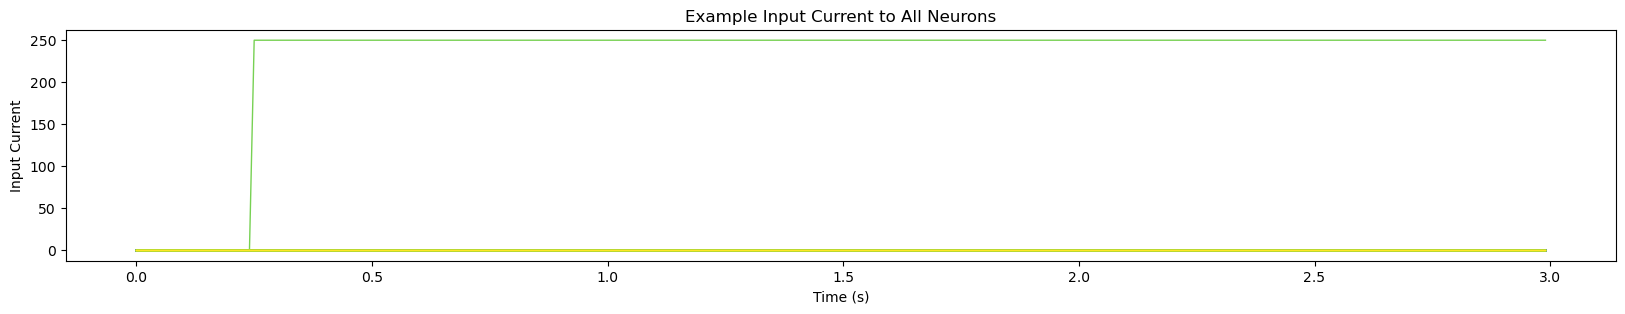

In [70]:
driving_input = inputF.get_full_input_data()
fig, ax = plt.subplots(figsize=(20, 3))
num_neurons_to_plot = min(40, num_neurons)
for n in range(num_neurons_to_plot):
    for b in range(batch_size):
        ax.plot(
            jnp.arange(num_timesteps)[::10] * dt,
            driving_input[::10, b, n],
            color=plt.cm.viridis(n / (num_neurons_to_plot - 1)),
            lw=1,
        )
ax.set_xlabel("Time (s)")
ax.set_ylabel("Input Current")
ax.set_title("Example Input Current to All Neurons")
plt.show()

# Setup the VNC-RNN

In [71]:
vncRnn = create_random_network(
    num_neurons=num_neurons,
    dt=dt,
    weights=weights,
    activation_function="scaled_tanh_relu",
    gains_stats={
        "distribution": "normal",
        "mean": 1.0,
        "std": 0.2,
    },
    max_firing_rates_stats={
        "distribution": "normal",
        "mean": 200.0,
        "std": 15.0,
    },
    thresholds_stats={
        "distribution": "normal",
        "mean": 4.0,
        "std": 0.5,
    },
    time_constants_stats={
        "distribution": "normal",
        "mean": 20e-3,
        "std": 2.5e-3,
    },
    neuron_size_scale=neuron_size_scale,
    random_seed=seed + 2,
)

## Qualitatively check distribution of random parameters

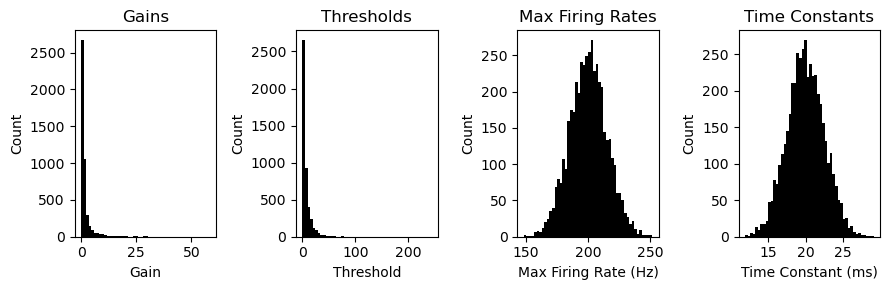

In [72]:
fig, axes = plt.subplots(1, 4, figsize=(9, 3))
axes[0].hist(vncRnn.gains, bins=50, color="k")
axes[0].set_title("Gains")
axes[0].set_xlabel("Gain")
axes[0].set_ylabel("Count")
axes[1].hist(vncRnn.thresholds, bins=50, color="k")
axes[1].set_title("Thresholds")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Count")
axes[2].hist(vncRnn.max_firing_rates, bins=50, color="k")
axes[2].set_title("Max Firing Rates")
axes[2].set_xlabel("Max Firing Rate (Hz)")
axes[2].set_ylabel("Count")
axes[3].hist(vncRnn.time_constants * 1e3, bins=50, color="k")
axes[3].set_title("Time Constants")
axes[3].set_xlabel("Time Constant (ms)")
axes[3].set_ylabel("Count")
plt.tight_layout()
plt.show()

# Simulate VNC-RNN

In [76]:
firing_rates = vncRnn.simulate(
    num_timesteps=num_timesteps,
    input_func=inputF,
    input_noise_std=0.21,
    recurrent_noise_std=0.21,
    input_noise_tau=1.0,
    recurrent_noise_tau=1.0,
    initial_state=None,
    batch_size=inputF.batch_size,
)

In [77]:
firing_rates.shape  # should be (num_timesteps, batch_size, num_neurons)

(3001, 1, 4561)

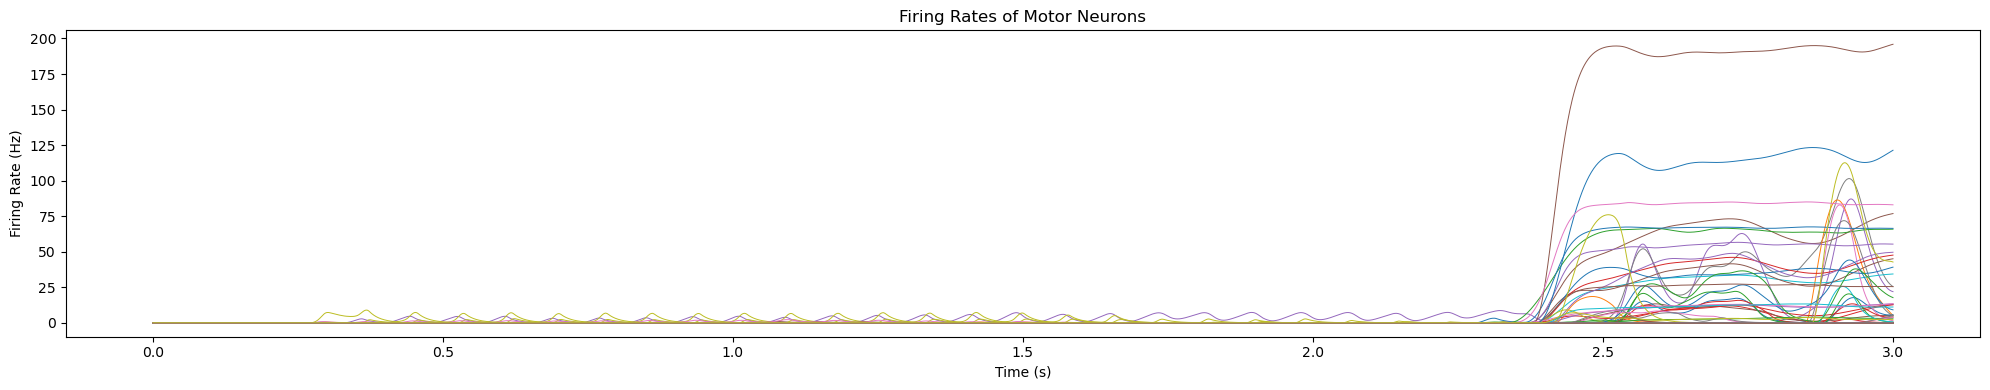

In [82]:
mn_indices = jnp.where((neuron_properties["class"] == "motor neuron").to_numpy())[0]
mn_firing_rates = firing_rates[:, :, mn_indices]

fig, ax = plt.subplots(figsize=(20, 4))
for b in range(batch_size):
    ax.plot(
        jnp.arange(num_timesteps + 1) * dt,
        mn_firing_rates[:, b, :],
        lw=0.7,
    )
ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing Rate (Hz)")
ax.set_title("Firing Rates of Motor Neurons")
plt.tight_layout()
# plt.ylim(1e-1)
# plt.yscale("log")
plt.show()

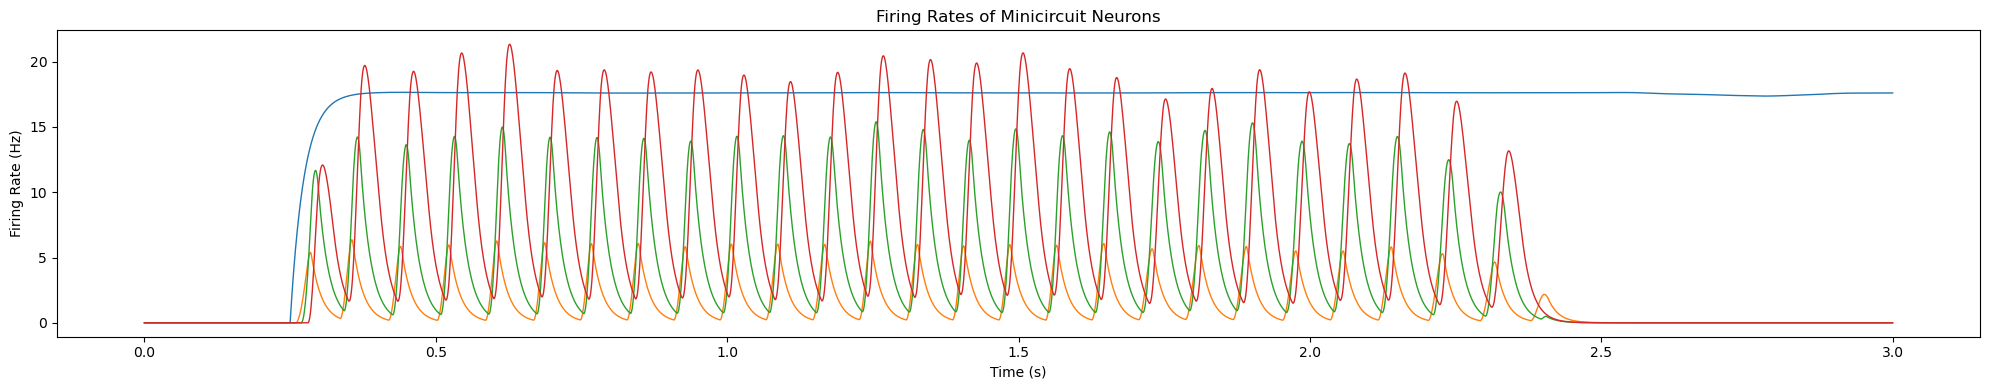

In [83]:
mini_circuit_body_IDs = [10093, 10707, 11751, 13905]
minicircuit_indices = jnp.where((neuron_properties["bodyId"].isin(mini_circuit_body_IDs)).to_numpy())[0]
minicircuit_firing_rates = firing_rates[:, :, minicircuit_indices]
batch_id = 0

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(jnp.arange(num_timesteps + 1) * dt, minicircuit_firing_rates[:, batch_id, :], lw=1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing Rate (Hz)")
ax.set_title("Firing Rates of Minicircuit Neurons")
plt.tight_layout()
plt.show()

# Make combined plots

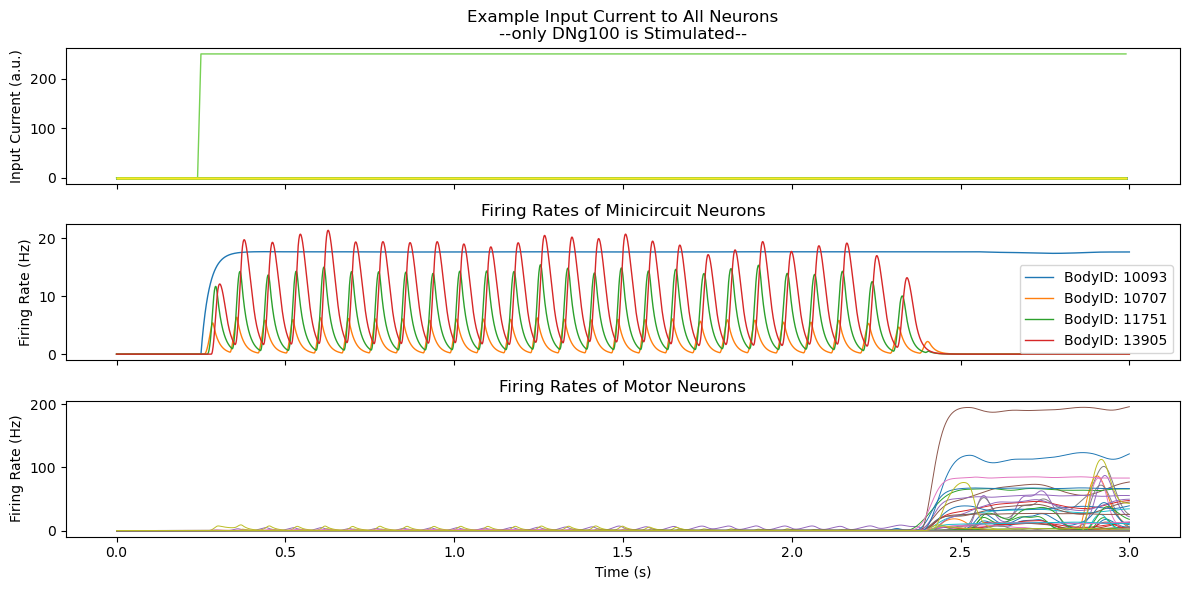

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
driving_input = inputF.get_full_input_data()
num_neurons_to_plot = min(40, num_neurons)
for n in range(num_neurons_to_plot):
    for b in range(batch_size):
        axes[0].plot(
            jnp.arange(num_timesteps)[::10] * dt,
            driving_input[::10, b, n],
            color=plt.cm.viridis(n / (num_neurons_to_plot - 1)),
            lw=1,
        )
axes[0].set_ylabel("Input Current (a.u.)")
axes[0].set_title("Example Input Current to All Neurons\n--only DNg100 is Stimulated--")

batch_id = 0
mini_circuit_body_IDs = [10093, 10707, 11751, 13905]
minicircuit_indices = jnp.where((neuron_properties["bodyId"].isin(mini_circuit_body_IDs)).to_numpy())[0]
minicircuit_firing_rates = firing_rates[:, :, minicircuit_indices]
axes[1].plot(jnp.arange(num_timesteps + 1) * dt, minicircuit_firing_rates[:, batch_id, :], lw=1)
axes[1].set_ylabel("Firing Rate (Hz)")
axes[1].set_title("Firing Rates of Minicircuit Neurons")
axes[1].legend(["BodyID: " + str(bid) for bid in mini_circuit_body_IDs])

mn_indices = jnp.where((neuron_properties["class"] == "motor neuron").to_numpy())[0]
mn_firing_rates = firing_rates[:, :, mn_indices]
axes[2].plot(
    jnp.arange(num_timesteps + 1) * dt,
    mn_firing_rates[:, batch_id, :],
    lw=0.7,
)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Firing Rate (Hz)")
axes[2].set_title("Firing Rates of Motor Neurons")
plt.tight_layout()
plt.show()